In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

ImportError: No module named xgboost.sklearn

In [8]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [500] # (200: 100 um, 500: 250 um)
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Load training dataset


In [50]:
training_dataset_ids = [99]
training_features, training_addresses = merge_datasets(training_dataset_ids, labels_to_sample=labels_to_sample)

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (196608000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


[(8400, 8624, 11816, 12040)]
[(9184, 9408, 12320, 12544), (8456, 8680, 11928, 12152)]
[(8624, 8848, 11760, 11984)]
[(8624, 8848, 11928, 12152), (8344, 8568, 11312, 11536)]
[(8456, 8680, 11536, 11760)]
[(8288, 8512, 11592, 11816)]
[(9240, 9464, 12880, 13104), (8624, 8848, 11648, 11872)]


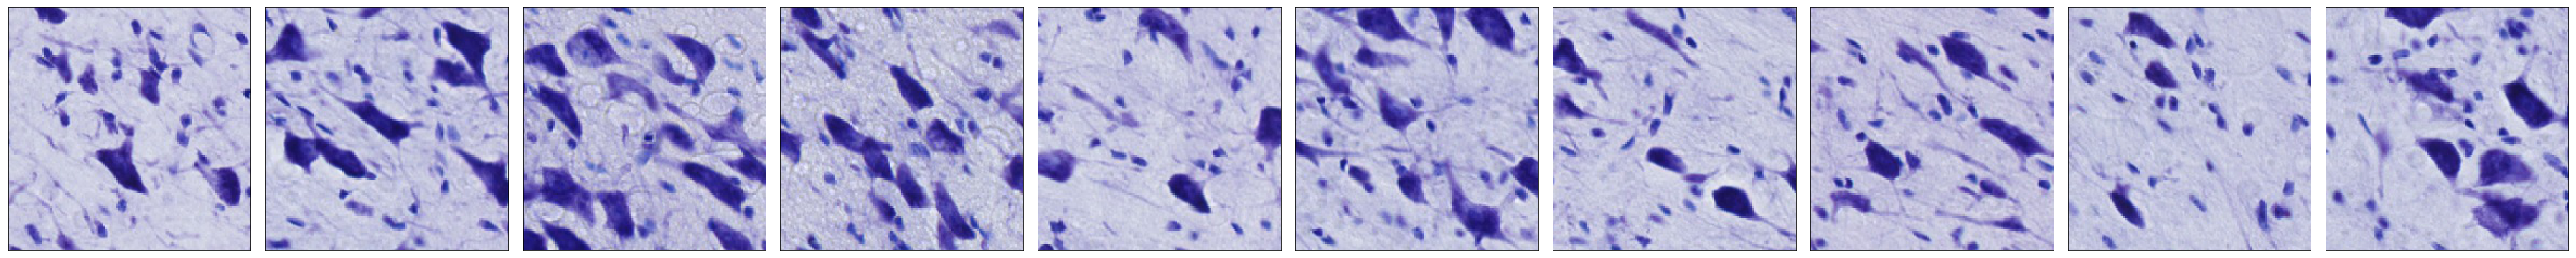

In [53]:
# Visualize training patches

patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches, nc=10)


# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [57]:
assert set(training_addresses.keys()) == set(training_features.keys()), \
'Training features and training addresses are not consistent.'

In [58]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

# Train Classifiers

In [59]:
setting = 99
properties = learning_setting_properties[setting]

setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % setting))
margin = 500

In [61]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if properties['neg_composition'] == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif properties['neg_composition'] == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif properties['neg_composition'] == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if properties['sample_weighting'] == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if properties['model'] == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif properties['model'] == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif properties['model'] == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif properties['model'] == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif properties['model'] == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif properties['model'] == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=setting))
    
    joblib.dump(clf, clf_fp)
    
    transfer_data_synced(relative_to_ec2(clf_fp), 
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=False)

Tz
      Iter       Train Loss   Remaining Time 
         1           0.9649            0.41s
         2           0.8017            0.32s
         3           0.6857            0.29s
         4           0.6078            0.28s
         5           0.5333            0.27s
         6           0.4656            0.26s
         7           0.3990            0.25s
         8           0.3600            0.24s
         9           0.3065            0.24s
        10           0.2700            0.23s
        20           0.0808            0.20s
        30           0.0268            0.17s
        40           0.0091            0.14s
        50           0.0031            0.12s
        60           0.0011            0.10s
        70           0.0004            0.07s
        80           0.0004            0.04s
        90           0.0004            0.02s
       100           0.0004            0.00s


Fitting classifier: 0.17 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Tz_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/Tz_clf_setting_99.dump


Child returned 0
0.42 seconds.


Sp5O
      Iter       Train Loss   Remaining Time 
         1           1.1250            0.23s
         2           1.0049            0.22s
         3           0.9011            0.22s
         4           0.8090            0.22s
         5           0.7163            0.22s
         6           0.6510            0.21s
         7           0.6182            0.20s
         8           0.5615            0.20s
         9           0.5079            0.20s
        10           0.4432            0.20s
        20           0.1904            0.17s
        30           0.0840            0.15s
        40           0.0380            0.13s
        50           0.0203            0.10s
        60           0.0102            0.08s
        70           0.0049            0.06s
        80           0.0024            0.04s
        90           0.0011            0.02s
       100           0.0006            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5O_clf_setting_99.dump s3://mouseb

Fitting classifier: 0.21 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.17 seconds


7n
      Iter       Train Loss   Remaining Time 
         1           0.8584            0.27s
         2           0.6629            0.30s
         3           0.5333            0.31s
         4           0.4309            0.32s
         5           0.3669            0.30s
         6           0.3005            0.30s
         7           0.2629            0.29s
         8           0.2131            0.28s
         9           0.1829            0.28s
        10           0.1609            0.27s
        20           0.0398            0.23s
        30           0.0115            0.19s
        40           0.0032            0.17s
        50           0.0009            0.14s
        60           0.0003            0.10s
        70           0.0003            0.07s
        80           0.0003            0.04s
        90           0.0003            0.02s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/7n_clf_setting_99.dump s3://mousebrain

Child returned 0
0.37 seconds.



DC
      Iter       Train Loss   Remaining Time 
         1           0.9715            0.30s
         2           0.8622            0.35s
         3           0.7597            0.36s
         4           0.6790            0.34s
         5           0.5780            0.34s
         6           0.4930            0.37s
         7           0.4525            0.36s
         8           0.4048            0.36s
         9           0.3681            0.35s
        10           0.3198            0.35s
        20           0.0962            0.31s
        30           0.0331            0.27s
        40           0.0132            0.23s
        50           0.0045            0.20s
        60           0.0016            0.16s
        70           0.0006            0.12s
        80           0.0005            0.07s
        90           0.0005            0.03s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/DC_clf_setting_99.dump s3://mousebrai

Fitting classifier: 0.29 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.11 seconds


5N
      Iter       Train Loss   Remaining Time 
         1           1.1434            0.11s
         2           0.9805            0.11s
         3           0.7965            0.13s
         4           0.7126            0.12s
         5           0.6380            0.12s
         6           0.5846            0.11s
         7           0.4944            0.12s
         8           0.4253            0.12s
         9           0.3906            0.12s
        10           0.3403            0.12s
        20           0.1438            0.10s
        30           0.0597            0.08s
        40           0.0253            0.07s
        50           0.0113            0.06s
        60           0.0057            0.05s
        70           0.0025            0.03s
        80           0.0013            0.02s
        90           0.0006            0.01s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/5N_clf_setting_99.dump s3://mousebrain

Child returned 0
0.37 seconds.
Fitting classifier: 0.18 seconds


3N
      Iter       Train Loss   Remaining Time 
         1           1.0975            0.22s
         2           0.9400            0.22s
         3           0.8302            0.22s
         4           0.7610            0.20s
         5           0.6788            0.20s
         6           0.6320            0.19s
         7           0.5631            0.19s
         8           0.4922            0.19s
         9           0.4621            0.18s
        10           0.4039            0.18s
        20           0.1552            0.16s
        30           0.0650            0.14s
        40           0.0261            0.12s
        50           0.0118            0.10s
        60           0.0051            0.08s
        70           0.0021            0.06s
        80           0.0009            0.04s
        90           0.0005            0.02s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/3N_clf_setting_99.dump s3://mousebrain

Child returned 0
0.37 seconds.


Pn
      Iter       Train Loss   Remaining Time 
         1           0.9765            0.38s
         2           0.8269            0.37s
         3           0.7426            0.33s
         4           0.6648            0.31s
         5           0.5880            0.32s
         6           0.5210            0.32s
         7           0.4583            0.32s
         8           0.4035            0.31s
         9           0.3519            0.31s
        10           0.3225            0.30s
        20           0.1048            0.27s
        30           0.0378            0.23s
        40           0.0132            0.20s
        50           0.0047            0.17s
        60           0.0016            0.13s
        70           0.0005            0.10s
        80           0.0004            0.06s
        90           0.0004            0.03s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Pn_clf_setting_99.dump s3://mousebrain

Fitting classifier: 0.25 seconds
Child returned 0
0.37 seconds.


10N
      Iter       Train Loss   Remaining Time 
         1           0.8613            0.30s
         2           0.6983            0.41s
         3           0.5926            0.40s
         4           0.4852            0.42s
         5           0.4082            0.41s
         6           0.3541            0.41s
         7           0.2942            0.41s
         8           0.2563            0.40s
         9           0.2260            0.40s
        10           0.1959            0.39s
        20           0.0529            0.33s
        30           0.0136            0.28s
        40           0.0038            0.24s
        50           0.0010            0.20s
        60           0.0004            0.15s
        70           0.0004            0.10s
        80           0.0004            0.06s
        90           0.0004            0.03s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/10N_clf_setting_99.dump s3://mousebra

Fitting classifier: 0.24 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.08 seconds


LC
      Iter       Train Loss   Remaining Time 
         1           1.0593            0.09s
         2           0.8609            0.09s
         3           0.7322            0.09s
         4           0.6307            0.09s
         5           0.5499            0.09s
         6           0.4812            0.09s
         7           0.4271            0.09s
         8           0.3800            0.09s
         9           0.3399            0.08s
        10           0.3011            0.08s
        20           0.1172            0.07s
        30           0.0484            0.06s
        40           0.0214            0.05s
        50           0.0094            0.04s
        60           0.0043            0.03s
        70           0.0019            0.02s
        80           0.0009            0.02s
        90           0.0004            0.01s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/LC_clf_setting_99.dump s3://mousebrain

Child returned 0
0.43 seconds.
Fitting classifier: 0.11 seconds


7N
      Iter       Train Loss   Remaining Time 
         1           1.1016            0.18s
         2           0.9967            0.15s
         3           0.8916            0.13s
         4           0.8146            0.13s
         5           0.7517            0.12s
         6           0.6960            0.12s
         7           0.6524            0.12s
         8           0.6071            0.11s
         9           0.5690            0.11s
        10           0.5297            0.11s
        20           0.2343            0.09s
        30           0.1305            0.08s
        40           0.0762            0.07s
        50           0.0407            0.06s
        60           0.0237            0.04s
        70           0.0130            0.03s
        80           0.0073            0.02s
        90           0.0037            0.01s
       100           0.0020            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/7N_clf_setting_99.dump s3://mousebrain

Child returned 0
0.43 seconds.
Fitting classifier: 0.16 seconds


Amb
      Iter       Train Loss   Remaining Time 
         1           0.8717            0.26s
         2           0.6884            0.30s
         3           0.5299            0.31s
         4           0.4439            0.29s
         5           0.3617            0.30s
         6           0.3076            0.29s
         7           0.2600            0.29s
         8           0.2233            0.29s
         9           0.1889            0.29s
        10           0.1496            0.29s
        20           0.0362            0.23s
        30           0.0089            0.20s
        40           0.0024            0.17s
        50           0.0006            0.14s
        60           0.0004            0.10s
        70           0.0004            0.07s
        80           0.0004            0.04s
        90           0.0004            0.02s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Amb_clf_setting_99.dump s3://mousebra

Child returned 0
0.42 seconds.


12N
      Iter       Train Loss   Remaining Time 
         1           0.8556            0.42s
         2           0.6799            0.41s
         3           0.5723            0.40s
         4           0.4726            0.40s
         5           0.4069            0.40s
         6           0.3542            0.39s
         7           0.2920            0.38s
         8           0.2490            0.38s
         9           0.2112            0.39s
        10           0.1823            0.39s
        20           0.0453            0.34s
        30           0.0115            0.30s
        40           0.0033            0.26s
        50           0.0009            0.21s
        60           0.0004            0.16s
        70           0.0004            0.10s
        80           0.0004            0.06s
        90           0.0004            0.03s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/12N_clf_setting_99.dump s3://mousebra

Fitting classifier: 0.25 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.08 seconds


RMC
      Iter       Train Loss   Remaining Time 
         1           1.1899            0.10s
         2           1.0507            0.10s
         3           0.9299            0.10s
         4           0.8429            0.09s
         5           0.7734            0.09s
         6           0.7144            0.09s
         7           0.6587            0.09s
         8           0.6064            0.09s
         9           0.5585            0.09s
        10           0.5169            0.09s
        20           0.2673            0.07s
        30           0.1518            0.06s
        40           0.0893            0.05s
        50           0.0537            0.04s
        60           0.0328            0.03s
        70           0.0201            0.02s
        80           0.0126            0.02s
        90           0.0077            0.01s
       100           0.0047            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/RMC_clf_setting_99.dump s3://mousebra

Child returned 0
0.43 seconds.


VCA
      Iter       Train Loss   Remaining Time 
         1           0.9360            0.31s
         2           0.8138            0.36s
         3           0.7254            0.37s
         4           0.6436            0.38s
         5           0.5674            0.38s
         6           0.5218            0.36s
         7           0.4652            0.36s
         8           0.4116            0.36s
         9           0.3773            0.36s
        10           0.3411            0.36s
        20           0.1207            0.32s
        30           0.0453            0.27s
        40           0.0167            0.23s
        50           0.0059            0.20s
        60           0.0021            0.16s
        70           0.0007            0.12s
        80           0.0005            0.07s
        90           0.0005            0.03s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VCA_clf_setting_99.dump s3://mousebra

Fitting classifier: 0.30 seconds
Child returned 0
0.43 seconds.


Sp5I
      Iter       Train Loss   Remaining Time 
         1           0.9591            0.42s
         2           0.8039            0.41s
         3           0.6902            0.45s
         4           0.5916            0.43s
         5           0.5316            0.42s
         6           0.4737            0.42s
         7           0.4073            0.41s
         8           0.3666            0.40s
         9           0.3109            0.40s
        10           0.2668            0.39s
        20           0.0871            0.32s
        30           0.0266            0.27s
        40           0.0092            0.23s
        50           0.0031            0.19s
        60           0.0011            0.15s
        70           0.0005            0.11s
        80           0.0005            0.07s
        90           0.0005            0.03s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5I_clf_setting_99.dump s3://mouseb

Fitting classifier: 0.27 seconds
Child returned 0
0.37 seconds.


Sp5C
      Iter       Train Loss   Remaining Time 
         1           0.9729            0.34s
         2           0.8551            0.29s
         3           0.7601            0.28s
         4           0.6667            0.26s
         5           0.5979            0.26s
         6           0.5206            0.25s
         7           0.4678            0.26s
         8           0.4155            0.25s
         9           0.3739            0.25s
        10           0.3424            0.24s
        20           0.1245            0.21s
        30           0.0499            0.18s
        40           0.0195            0.16s
        50           0.0077            0.13s
        60           0.0030            0.10s
        70           0.0012            0.08s
        80           0.0005            0.05s
        90           0.0005            0.02s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5C_clf_setting_99.dump s3://mouseb

Fitting classifier: 0.22 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.15 seconds


4N
      Iter       Train Loss   Remaining Time 
         1           1.0766            0.23s
         2           0.8777            0.22s
         3           0.7334            0.22s
         4           0.6252            0.22s
         5           0.5297            0.21s
         6           0.4691            0.21s
         7           0.4149            0.21s
         8           0.3685            0.21s
         9           0.3151            0.20s
        10           0.2722            0.21s
        20           0.0846            0.17s
        30           0.0257            0.15s
        40           0.0081            0.13s
        50           0.0026            0.11s
        60           0.0009            0.08s
        70           0.0005            0.06s
        80           0.0005            0.03s
        90           0.0005            0.02s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/4N_clf_setting_99.dump s3://mousebrain

Child returned 0
0.42 seconds.


AP
      Iter       Train Loss   Remaining Time 
         1           0.8160            0.29s
         2           0.6542            0.35s
         3           0.5521            0.36s
         4           0.4614            0.36s
         5           0.3942            0.36s
         6           0.3364            0.36s
         7           0.2885            0.36s
         8           0.2482            0.36s
         9           0.2206            0.35s
        10           0.1925            0.34s
        20           0.0344            0.32s
        30           0.0077            0.28s
        40           0.0016            0.25s
        50           0.0004            0.20s
        60           0.0004            0.14s
        70           0.0004            0.09s
        80           0.0004            0.05s
        90           0.0004            0.02s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/AP_clf_setting_99.dump s3://mousebrain

Fitting classifier: 0.22 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.16 seconds


PBG
      Iter       Train Loss   Remaining Time 
         1           0.8761            0.24s
         2           0.6760            0.28s
         3           0.5454            0.29s
         4           0.4628            0.27s
         5           0.3861            0.28s
         6           0.3204            0.28s
         7           0.2803            0.27s
         8           0.2369            0.27s
         9           0.2078            0.26s
        10           0.1679            0.26s
        20           0.0343            0.23s
        30           0.0096            0.19s
        40           0.0027            0.16s
        50           0.0007            0.14s
        60           0.0004            0.10s
        70           0.0004            0.06s
        80           0.0004            0.04s
        90           0.0004            0.02s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/PBG_clf_setting_99.dump s3://mousebra

Child returned 0
0.37 seconds.


LRt
      Iter       Train Loss   Remaining Time 
         1           0.9780            0.24s
         2           0.8695            0.24s
         3           0.7740            0.24s
         4           0.6778            0.24s
         5           0.5591            0.25s
         6           0.4948            0.26s
         7           0.4404            0.26s
         8           0.3796            0.25s
         9           0.3482            0.25s
        10           0.3183            0.24s
        20           0.1263            0.20s
        30           0.0480            0.18s
        40           0.0197            0.15s
        50           0.0073            0.12s
        60           0.0031            0.10s
        70           0.0013            0.07s
        80           0.0006            0.05s
        90           0.0005            0.02s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/LRt_clf_setting_99.dump s3://mousebra

Fitting classifier: 0.21 seconds
Child returned 0
0.37 seconds.
Fitting classifier: 0.19 seconds


IC
      Iter       Train Loss   Remaining Time 
         1           1.1358            0.13s
         2           0.9980            0.18s
         3           0.9300            0.16s
         4           0.8367            0.17s
         5           0.7481            0.18s
         6           0.7053            0.17s
         7           0.6681            0.16s
         8           0.6118            0.16s
         9           0.5424            0.17s
        10           0.4819            0.17s
        20           0.1860            0.16s
        30           0.0887            0.13s
        40           0.0487            0.11s
        50           0.0250            0.09s
        60           0.0128            0.07s
        70           0.0067            0.05s
        80           0.0028            0.04s
        90           0.0014            0.02s
       100           0.0008            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/IC_clf_setting_99.dump s3://mousebrain

Child returned 0
0.37 seconds.
Fitting classifier: 0.14 seconds


VLL
      Iter       Train Loss   Remaining Time 
         1           1.0044            0.21s
         2           0.8594            0.21s
         3           0.7436            0.20s
         4           0.6761            0.18s
         5           0.5816            0.18s
         6           0.5124            0.18s
         7           0.4710            0.17s
         8           0.4384            0.16s
         9           0.3846            0.16s
        10           0.3576            0.16s
        20           0.0965            0.15s
        30           0.0344            0.12s
        40           0.0119            0.11s
        50           0.0047            0.09s
        60           0.0021            0.07s
        70           0.0007            0.05s
        80           0.0005            0.03s
        90           0.0005            0.01s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VLL_clf_setting_99.dump s3://mousebra

Child returned 0
0.37 seconds.


VCP
      Iter       Train Loss   Remaining Time 
         1           0.9194            0.41s
         2           0.7865            0.45s
         3           0.6218            0.42s
         4           0.5159            0.41s
         5           0.4190            0.40s
         6           0.3371            0.39s
         7           0.2873            0.38s
         8           0.2559            0.36s
         9           0.2132            0.36s
        10           0.1862            0.35s
        20           0.0451            0.31s
        30           0.0121            0.26s
        40           0.0028            0.23s
        50           0.0008            0.19s
        60           0.0004            0.14s
        70           0.0004            0.09s
        80           0.0004            0.05s
        90           0.0004            0.02s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VCP_clf_setting_99.dump s3://mousebra

Fitting classifier: 0.22 seconds
Child returned 0
0.42 seconds.
Fitting classifier: 0.17 seconds


SNC
      Iter       Train Loss   Remaining Time 
         1           1.0212            0.30s
         2           0.9125            0.21s
         3           0.7820            0.21s
         4           0.6907            0.21s
         5           0.6198            0.21s
         6           0.5573            0.20s
         7           0.5207            0.19s
         8           0.4715            0.19s
         9           0.4169            0.19s
        10           0.3933            0.18s
        20           0.1444            0.16s
        30           0.0583            0.13s
        40           0.0230            0.12s
        50           0.0096            0.10s
        60           0.0038            0.08s
        70           0.0014            0.06s
        80           0.0005            0.04s
        90           0.0005            0.02s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SNC_clf_setting_99.dump s3://mousebra

Child returned 0
0.47 seconds.
Fitting classifier: 0.13 seconds



6N
      Iter       Train Loss   Remaining Time 
         1           0.9526            0.22s
         2           0.7245            0.26s
         3           0.5995            0.24s
         4           0.4964            0.24s
         5           0.4070            0.23s
         6           0.3458            0.23s
         7           0.3069            0.21s
         8           0.2666            0.21s
         9           0.2258            0.20s
        10           0.2000            0.20s
        20           0.0544            0.17s
        30           0.0170            0.14s
        40           0.0054            0.12s
        50           0.0016            0.10s
        60           0.0005            0.08s
        70           0.0004            0.05s
        80           0.0004            0.03s
        90           0.0004            0.01s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/6N_clf_setting_99.dump s3://mousebrai

Child returned 0
0.37 seconds.


SNR
      Iter       Train Loss   Remaining Time 
         1           0.8655            0.33s
         2           0.7197            0.45s
         3           0.6089            0.48s
         4           0.5352            0.46s
         5           0.4532            0.45s
         6           0.3976            0.44s
         7           0.3372            0.45s
         8           0.2968            0.45s
         9           0.2483            0.45s
        10           0.2215            0.45s
        20           0.0530            0.41s
        30           0.0142            0.36s
        40           0.0036            0.31s
        50           0.0010            0.26s
        60           0.0004            0.19s
        70           0.0004            0.13s
        80           0.0004            0.07s
        90           0.0004            0.03s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SNR_clf_setting_99.dump s3://mousebra

Fitting classifier: 0.31 seconds
Child returned 0
0.37 seconds.


SC
      Iter       Train Loss   Remaining Time 
         1           1.0875            0.22s
         2           0.9981            0.17s
         3           0.9361            0.16s
         4           0.8077            0.17s
         5           0.7184            0.17s
         6           0.6392            0.18s
         7           0.5690            0.18s
         8           0.5119            0.18s
         9           0.4669            0.18s
        10           0.4178            0.18s
        20           0.1902            0.15s
        30           0.0901            0.14s
        40           0.0407            0.12s
        50           0.0184            0.10s
        60           0.0081            0.08s
        70           0.0037            0.06s
        80           0.0020            0.04s
        90           0.0009            0.02s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 0.20 seconds
Child returned 0
0.42 seconds.


RtTg
      Iter       Train Loss   Remaining Time 
         1           1.0058            0.40s
         2           0.8609            0.40s
         3           0.7528            0.39s
         4           0.6719            0.39s
         5           0.6074            0.36s
         6           0.5173            0.36s
         7           0.4504            0.36s
         8           0.3977            0.36s
         9           0.3591            0.36s
        10           0.3169            0.36s
        20           0.1134            0.30s
        30           0.0419            0.26s
        40           0.0142            0.22s
        50           0.0048            0.19s
        60           0.0017            0.15s
        70           0.0007            0.11s
        80           0.0005            0.07s
        90           0.0005            0.03s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/RtTg_clf_setting_99.dump s3://mouseb

Fitting classifier: 0.29 seconds
Child returned 0
0.37 seconds.


# Load pre-computed classifiers

In [62]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    download_from_s3_if_not_exists(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump && mkdir -p /shared/CSHL_classifiers/setting_99/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump /shared/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump


Child returned 0
Child returned 1
0.37 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump && mkdir -p /shared/CSHL_classifiers/setting_99/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump /shared/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump


Child returned 1
0.37 seconds.
Classifier for outerContour is not found.


In [63]:
margin = 500

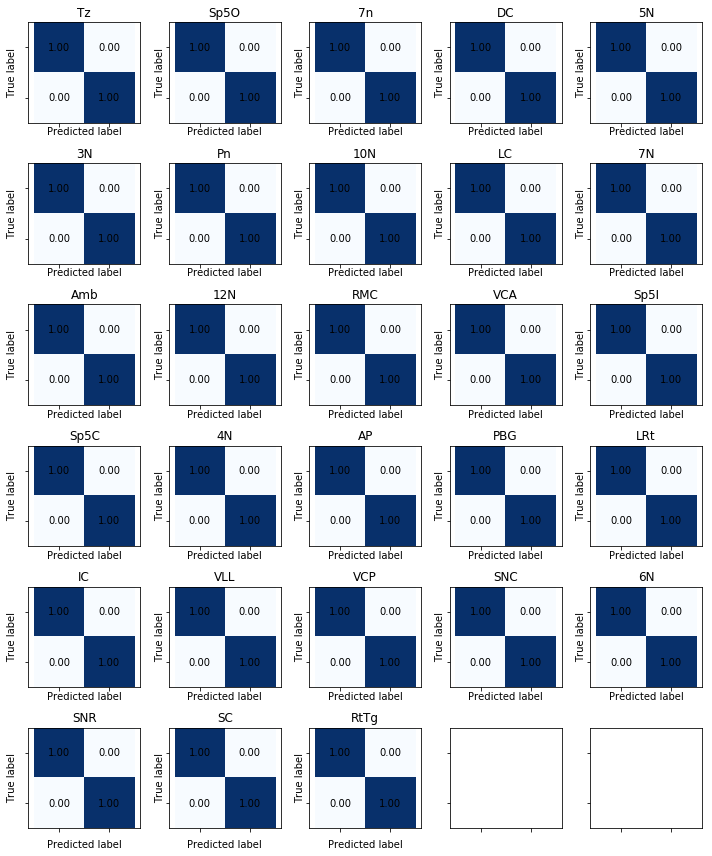

In [64]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if properties['neg_composition'] == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif properties['neg_composition'] == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif properties['neg_composition'] == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [65]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.999669077785


In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg